# Using DQN and Double DQN in Pearl with different neural network instantiations.

Here is a [better rendering](https://nbviewer.org/github/facebookresearch/Pearl/blob/main/tutorials/sequential_decision_making/DQN_and_DoubleDQN_example.ipynb) of this notebook on [nbviewer](https://nbviewer.org/).

- The purpose of this tutorial is twofold. First, it illustrates how users can use implementations of value based methods, for example, DQN and Double DQN, in Pearl. We use a simple Gym environment for illustration.

- Second, it illustrates how users can instantiate a neural network (outside of a Pearl Agent) and pass it to different policy learners in Pearl. For both examples (DQN and Double DQN), we use an instantiation of `QValueNetworks` outside of the Pearl Agent. The default way right now is to instantiate a Q-value network inside the agent's policy learner.

- Users can also instantiate custom networks and use these with different policy learners in Pearl, but are expected to follow the general design of the value networks/critic networks/actor networks base class. For example, for value based methods such as DQN and Double DQN, users should follow the design of the `QValueNetwork` base class.

In [1]:
%load_ext autoreload
%autoreload 2

# Pearl Installation

If you haven't installed Pearl, please make sure you install Pearl with the following cell. Otherwise, you can skip the cell below.



In [2]:
# Pearl installation from github. This install also includes PyTorch, Gym and Matplotlib

%pip uninstall Pearl -y
%rm -rf Pearl
!git clone https://github.com/facebookresearch/Pearl.git

Cloning into 'Pearl'...
remote: Enumerating objects: 6139, done.
remote: Counting objects: 100% (1284/1284), done.
remote: Compressing objects: 100% (248/248), done.
remote: Total 6139 (delta 1168), reused 1036 (delta 1036), pack-reused 4855 (from 1)
Receiving objects: 100% (6139/6139), 54.38 MiB | 7.57 MiB/s, done.
Resolving deltas: 100% (4223/4223), done.


In [10]:
%cd Pearl
%pip install .
%cd ..

/content/Pearl
Processing /content/Pearl
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for Pearl: filename=Pearl-0.1.0-py3-none-any.whl size=217767 sha256=7082f0bf3de0661f675f0242ffecd78de9c0d72885fb52b72d9eb917dc5cb50e
  Stored in directory: /tmp/pip-ephem-wheel-cache-pnf44wsk/wheels/83/80/1d/d9211ba70ee392341daf21a07252739e0cb2af9f95439a28cd
Successfully built Pearl


/content


In [5]:
!pip install swig

In [6]:
!pip install gymnasium[box2d]

zsh:1: no matches found: gymnasium[box2d]


# Import Modules

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from pearl.neural_networks.sequential_decision_making.q_value_networks import VanillaQValueNetwork
from pearl.utils.functional_utils.experimentation.set_seed import set_seed
from pearl.policy_learners.sequential_decision_making.deep_q_learning import DeepQLearning
from pearl.policy_learners.sequential_decision_making.double_dqn import DoubleDQN
from pearl.policy_learners.sequential_decision_making.ppo import ProximalPolicyOptimization
from pearl.replay_buffers.sequential_decision_making.fifo_off_policy_replay_buffer import FIFOOffPolicyReplayBuffer
from pearl.policy_learners.exploration_modules.common.epsilon_greedy_exploration import EGreedyExploration
from pearl.replay_buffers.sequential_decision_making.on_policy_replay_buffer import OnPolicyReplayBuffer
from pearl.utils.functional_utils.train_and_eval.online_learning import online_learning
from pearl.pearl_agent import PearlAgent
from pearl.utils.instantiations.environments.gym_environment import GymEnvironment
from pearl.utils.instantiations.spaces.discrete import DiscreteSpace
from pearl.action_representation_modules.one_hot_action_representation_module import (
    OneHotActionTensorRepresentationModule,
)

set_seed(0)

# Instantiate a simple Q value network

- In Pearl, Q-value networks assume inputs in the form of (state representation, action representation) and output estimated Q(s,a) through the `get_q_values` function.


In [ ]:
env = GymEnvironment("CartPole-v1", render_mode="rgb_array")
num_actions = env.action_space.n

# VanillaQValueNetwork class uses a simple mlp for approximating the Q values.
#  - Input dimension of the mlp = (state_dim + action_dim)
#  - Size of the intermediate layers are specified as list of `hidden_dims`.
hidden_dims = [64, 64]


# We will be using a one hot representation for representing actions. So take action_dim = num_actions.
Q_value_network = VanillaQValueNetwork(state_dim=env.observation_space.shape[0],  # dimension of the state representation
                                       action_dim=num_actions,                    # dimension of the action representation
                                       hidden_dims=hidden_dims,                   # dimensions of the intermediate layers
                                       output_dim=1)                              # set to 1 (Q values are scalars)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Example 1: Set up a simple DQN agent

In [ ]:
# Instead of using the 'network_type' argument, use the 'network_instance' argument.
# Pass Q_value_network as the `network_instance` to the `DeepQLearning` policy learner.
DQNagent = PearlAgent(
    policy_learner=DeepQLearning(
        state_dim=env.observation_space.shape[0],
        action_space=env.action_space,
        batch_size=64,
        training_rounds=10,
        soft_update_tau=0.75,
        network_instance=Q_value_network, # pass an instance of Q value network to the policy learner.
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=num_actions
        ),
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(10_000),
)

# Online interaction and learning

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


episode 20, step 192, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 10.0
episode 40, step 663, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 156.0
episode 60, step 2372, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 68.0
episode 80, step 6459, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 183.0
episode 100, step 15053, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 246.0
episode 120, step 24252, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 500.0
episode 140, step 33758, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 468.0
episode 160, step 41787, agent=PearlAgent with DeepQLearning, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 244.0
episode 180, step 47531, agent=PearlAgent with DeepQLearning

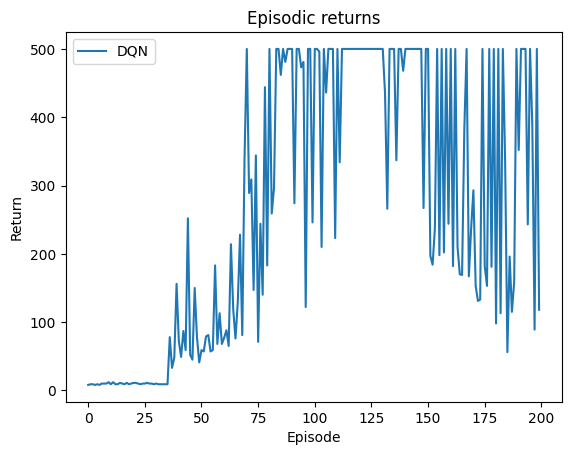

In [ ]:
# The online learning function in Pearl implements environment interaction and learning
# and returns a dictionary with episodic returns

info = online_learning(
    agent=DQNagent,
    env=env,
    number_of_episodes=200,
    print_every_x_episodes=20,   # print returns after every 10 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    seed=0
)

torch.save(info["return"], "DQN-return.pt")   # info["return"] refers to the episodic returns
plt.plot(np.arange(len(info["return"])), info["return"], label="DQN")
plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

# Example 2: Set up a simple Double DQN agent

In [ ]:
# Set up a different instance of a Q value network.

# We will be using a one hot representation for representing actions. So take action_dim = num_actions.
Q_network_DoubleDQN = VanillaQValueNetwork(state_dim=env.observation_space.shape[0],  # dimension of the state representation
                                       action_dim=num_actions,                        # dimension of the action representation
                                       hidden_dims=hidden_dims,                       # dimensions of the intermediate layers
                                       output_dim=1)                                  # set to 1 (Q values are scalars)


In [ ]:
# Instead of using the 'network_type' argument, use the 'network_instance' argument.
# Pass Q_value_network as the `network_instance` to the `DoubleDQN` policy learner.
DoubleDQNagent = PearlAgent(
    policy_learner=DoubleDQN(
        state_dim=env.observation_space.shape[0],
        action_space=env.action_space,
        batch_size=64,
        training_rounds=10,
        soft_update_tau=0.75,
        network_instance=Q_network_DoubleDQN,   # pass an instance of Q value network to the policy learner.
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=num_actions
        ),
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(10_000),
)

# Online interaction and learning

episode 20, step 208, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 8.0
episode 40, step 828, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 44.0
episode 60, step 1634, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 42.0
episode 80, step 4946, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 143.0
episode 100, step 9835, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 173.0
episode 120, step 15509, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 209.0
episode 140, step 21811, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 216.0
episode 160, step 30454, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 500.0
episode 180, step 39663, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPo

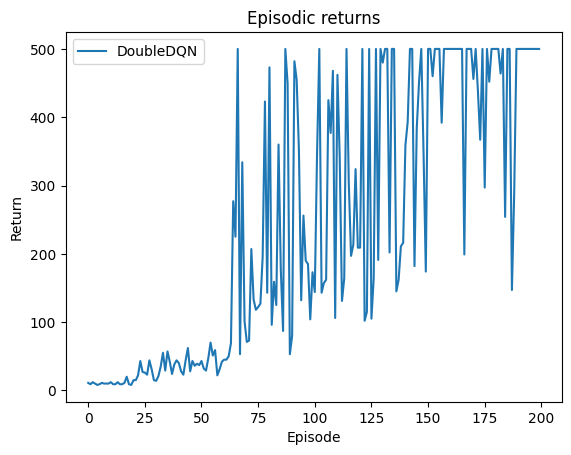

In [ ]:
# The online learning function in Pearl implements environment interaction and learning
# and returns a dictionary with episodic returns

info_DoubleDQN = online_learning(
    agent=DoubleDQNagent,
    env=env,
    number_of_episodes=200,
    print_every_x_episodes=20,   # print returns after every 10 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    seed=0
)

torch.save(info_DoubleDQN["return"], "DoubleDQN-return.pt")   # info["return"] refers to the episodic returns
plt.plot(np.arange(len(info_DoubleDQN["return"])), info_DoubleDQN["return"], label="DoubleDQN")
plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

In [ ]:
env = GymEnvironment("LunarLander-v2")
num_actions = env.action_space.n

# VanillaQValueNetwork class uses a simple mlp for approximating the Q values.
#  - Input dimension of the mlp = (state_dim + action_dim)
#  - Size of the intermediate layers are specified as list of `hidden_dims`.
hidden_dims = [64, 64]


# We will be using a one hot representation for representing actions. So take action_dim = num_actions.
Q_network_DoubleDQN = VanillaQValueNetwork(state_dim=env.observation_space.shape[0],  # dimension of the state representation
                                       action_dim=num_actions,                        # dimension of the action representation
                                       hidden_dims=hidden_dims,                       # dimensions of the intermediate layers
                                       output_dim=1)                                  # set to 1 (Q values are scalars)


# Instead of using the 'network_type' argument, use the 'network_instance' argument.
# Pass Q_value_network as the `network_instance` to the `DeepQLearning` policy learner.
DoubleDQNagent = PearlAgent(
    policy_learner=DoubleDQN(
        state_dim=env.observation_space.shape[0],
        action_space=env.action_space,
        batch_size=64,
        network_instance=Q_network_DoubleDQN,   # pass an instance of Q value network to the policy learner.
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=num_actions
        ),
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(1_000_000),
)

info_DoubleDQN = online_learning(
    agent=DoubleDQNagent,
    env=env,
    number_of_episodes=2000,
    print_every_x_episodes=50,   # print returns after every 50 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    seed=0
)

torch.save(info_DoubleDQN["return"], "DoubleDQN-return.pt")   # info["return"] refers to the episodic returns
plt.plot(np.arange(len(info_DoubleDQN["return"])), info_DoubleDQN["return"], label="DoubleDQN")
plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()
env.close()

KeyboardInterrupt: 

In [ ]:
env = GymEnvironment("LunarLander-v2")
print(f"Number of Actions: {env.action_space.n}")
print(f"Is the Environment Action Space Continuous: {env.action_space.is_continuous}")
print(f"Number of Observations: {env.observation_space.shape[0]}")
num_actions = env.action_space.n

hidden_dims = [64, 64]

action_representation_module = OneHotActionTensorRepresentationModule(
    max_number_actions= env.action_space.n,
)

assert isinstance(env.action_space, DiscreteSpace)
PPOagent = PearlAgent(
    policy_learner=ProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        action_space=env.action_space,
        actor_hidden_dims=hidden_dims,
        critic_hidden_dims=hidden_dims,
        #exploration_module=EntropyRegularizationExploration(0.01), #Add more exploriation to network
        use_critic=True,
        action_representation_module=action_representation_module,
    ),
    replay_buffer=OnPolicyReplayBuffer(1_000_000),
)

info_PPO = online_learning(
    agent=PPOagent,
    env=env,
    number_of_episodes=5000,
    print_every_x_episodes=50,   # print returns after every 10 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    seed=0
)

torch.save(info_PPO["return"], "PPO-return.pt")   # info["return"] refers to the episodic returns
plt.plot(np.arange(len(info_PPO["return"])), info_PPO["return"], label="PPO")
plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()
env.close()

Number of Actions: 4
Is the Environment Action Space Continuous: False
Number of Observations: 8


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


episode 50, step 4664, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: -139.48761016968638
episode 100, step 10758, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: -437.1380389109254


KeyboardInterrupt: 

In [ ]:
env = GymEnvironment("LunarLanderContinuous-v2")
print(env.action_space.action_dim)
print(env.action_space.is_continuous)
print(env.observation_space.shape[0])
num_actions = env.action_space

# VanillaQValueNetwork class uses a simple mlp for approximating the Q values.
#  - Input dimension of the mlp = (state_dim + action_dim)
#  - Size of the intermediate layers are specified as list of `hidden_dims`.
hidden_dims = [64, 64]

# Instead of using the 'network_type' argument, use the 'network_instance' argument.
# Pass Q_value_network as the `network_instance` to the `DeepQLearning` policy learner.

action_representation_module = OneHotActionTensorRepresentationModule(
    max_number_actions= env.action_space,
)

PPOagent = PearlAgent(
    policy_learner=ProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        action_space=env.action_space,
        actor_hidden_dims=hidden_dims,
        critic_hidden_dims=hidden_dims,
        use_critic=True,
        batch_size=64,
        training_rounds=10,
        action_representation_module=action_representation_module,
    ),
    replay_buffer=OnPolicyReplayBuffer(1_000_000),
)

info_PPO = online_learning(
    agent=PPOagent,
    env=env,
    number_of_episodes=5000,
    print_every_x_episodes=50,   # print returns after every 10 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    seed=0
)

torch.save(info_PPO["return"], "PPO-return.pt")   # info["return"] refers to the episodic returns
plt.plot(np.arange(len(info_PPO["return"])), info_PPO["return"], label="PPO")
plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

In [ ]:
env = GymEnvironment("CartPole-v1")
print(env.action_space.action_dim)
print(env.action_space.is_continuous)
print(env.observation_space.shape[0])
num_actions = env.action_space

num_actions = env.action_space.n
agent = PearlAgent(
    policy_learner=ProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        use_critic=True,
        action_space=env.action_space,
        actor_hidden_dims=[64, 64],
        critic_hidden_dims=[64, 64],
        training_rounds=100,
        batch_size=8,
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=num_actions,
        ),
    ),
    replay_buffer=OnPolicyReplayBuffer(100_000),
)

1
False
4


In [ ]:
num_actions = env.action_space.n
agent = PearlAgent(
    policy_learner=ProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        use_critic=True,
        action_space=env.action_space,
        actor_hidden_dims=[64, 64],
        critic_hidden_dims=[64, 64],
        training_rounds=100,
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=num_actions,
        ),
    ),
    replay_buffer=OnPolicyReplayBuffer(100_000),
)

print(agent.policy_learner._actor._model[0][0].weight)

# info_PPO = online_learning(
#     agent=agent,
#     env=env,
#     number_of_episodes=500,
#     print_every_x_episodes=20,   # print returns after every 10 episdoes
#     learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
#     seed=0
# )

# torch.save(info_PPO["return"], "DoubleDQN-return.pt")   # info["return"] refers to the episodic returns
# plt.plot(np.arange(len(info_PPO["return"])), info_PPO["return"], label="DoubleDQN")
# plt.title("Episodic returns")
# plt.xlabel("Episode")
# plt.ylabel("Return")
# plt.legend()
# plt.show()


In [ ]:
# observation, action_space = env.reset()
# agent.reset(observation, action_space)
# done = False
# while not done:
#     action = agent.act(exploit=False)
#     action_result = env.step(action)
#     agent.observe(action_result)
#     print(agent.learn())
#     done = action_result.done

info_PPO = online_learning(
    agent=agent,
    env=env,
    number_of_episodes=5000,
    print_every_x_episodes=50,   # print returns after every 10 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    seed=0
)

episode 50, step 1116, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 38.0
episode 100, step 2157, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 20.0
episode 150, step 3255, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 16.0
episode 200, step 4472, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 28.0
episode 250, step 5561, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 28.0
episode 300, step 6714, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 23.0
episode 350, step 7949, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 26.0
episode 400, step 9057, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 19.0


KeyboardInterrupt: 

In [ ]:
env = GymEnvironment("CartPole-v1")
print(env.action_space.action_dim)
print(env.action_space.is_continuous)
print(env.observation_space.shape[0])
num_actions = env.action_space
print(num_actions)

num_actions = env.action_space.n
print(num_actions)
agent = PearlAgent(
    policy_learner=ProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        use_critic=True,
        action_space=env.action_space,
        actor_hidden_dims=[64, 64],
        critic_hidden_dims=[64, 64],
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=num_actions,
        ),
    ),
    replay_buffer=OnPolicyReplayBuffer(100_000),
)

info_PPO = online_learning(
    agent=agent,
    env=env,
    number_of_episodes=5000,
    print_every_x_episodes=50,   # print returns after every 10 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    seed=0
)

# observation, action_space = env.reset()
# agent.reset(observation, action_space)
# done = False
# while not done:
#     action = agent.act(exploit=False)
#     print(action[0].item())
#     action_result = env.step(action)
#     print(action_result)
#     agent.observe(action_result)
#     agent.learn()
#     done = action_result.done

1
False
4
2
episode 50, step 1189, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 15.0
episode 100, step 2482, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 14.0
episode 150, step 3649, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 13.0
episode 200, step 4842, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 27.0
episode 250, step 6204, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 24.0
episode 300, step 7478, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 15.0
episode 350, step 8879, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 23.0
episode 400, step 10249, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
r

KeyboardInterrupt: 

In [ ]:
env_str = "CartPole-v1"
env = GymEnvironment(env_str)
print(f"Gym Environment: {env_str}")
print(f"Action Space Dimensions: {env.action_space.action_dim}")
print(f"Is Action Space Continuous: {env.action_space.is_continuous}")
print(f"Observation Space: {env.observation_space.shape[0]}")
print(f"Number of Actions: {env.action_space.n}")

DoubleDQNagent = PearlAgent(
    policy_learner=DoubleDQN(
        state_dim=env.observation_space.shape[0],
        action_space=env.action_space,
        hidden_dims=[64, 64],
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=env.action_space.n
        ),
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(1_000_000),
)

info_PPO = online_learning(
    agent=agent,
    env=env,
    number_of_episodes=3000,
    print_every_x_episodes=25,   # print returns after every 10 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    seed=0
)

torch.save(info_PPO["return"], "PPO-return.pt")   # info["return"] refers to the episodic returns
plt.plot(np.arange(len(info_PPO["return"])), info_PPO["return"], label="PPO")
plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

Gym Environment: CartPole-v1
Action Space Dimensions: 1
Is Action Space Continuous: False
Observation Space: 4
Number of Actions: 2


NameError: name 'agent' is not defined

Gym Environment: CartPole-v1
Action Space Dimensions: 1
Is Action Space Continuous: False
Observation Space: 4
Number of Actions: 2
0
episode 2, step 20, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 9.0
episode 4, step 40, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 10.0
episode 6, step 57, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 9.0
episode 8, step 78, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 12.0
episode 10, step 97, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 10.0
97


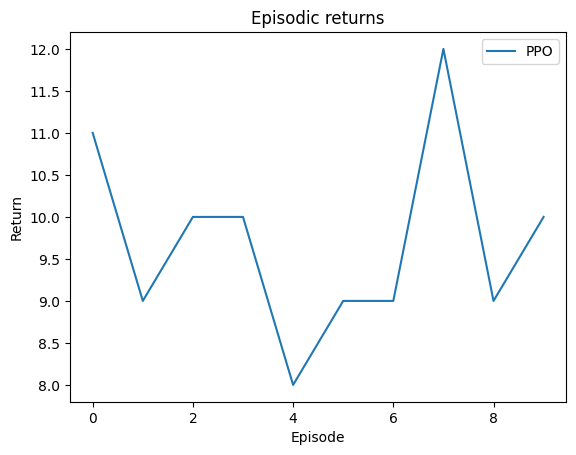

In [ ]:
env_str = "CartPole-v1"
env = GymEnvironment(env_str)
print(f"Gym Environment: {env_str}")
print(f"Action Space Dimensions: {env.action_space.action_dim}")
print(f"Is Action Space Continuous: {env.action_space.is_continuous}")
print(f"Observation Space: {env.observation_space.shape[0]}")
print(f"Number of Actions: {env.action_space.n}")

DoubleDQNagent = PearlAgent(
    policy_learner=DoubleDQN(
        state_dim=env.observation_space.shape[0],
        action_space=env.action_space,
        hidden_dims=[64, 64],
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=env.action_space.n
        ),
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(250_000),
)

print(len(DoubleDQNagent.replay_buffer.memory))

info_DoubleDQN = online_learning(
    agent=DoubleDQNagent,
    env=env,
    number_of_episodes=10,
    print_every_x_episodes=2,   # print returns after every 10 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    seed=0
)

print(len(DoubleDQNagent.replay_buffer.memory))

torch.save(info_DoubleDQN["return"], "DoubleDQN-return.pt")   # info["return"] refers to the episodic returns
plt.plot(np.arange(len(info_DoubleDQN["return"])), info_DoubleDQN["return"], label="PPO")
plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

# CarPole-v1

In [ ]:
env_str = "CartPole-v1"
env = GymEnvironment(env_str)
print(f"Gym Environment: {env_str}")
print(f"Observation Space: {env.observation_space.shape[0]}")
print(f"Number of Actions: {env.action_space.n}")
print(f"Action Space Dimensions: {env.action_space.action_dim}")
print(f"Is Action Space Continuous: {env.action_space.is_continuous}")
env.close()

Gym Environment: CartPole-v1
Observation Space: 4
Number of Actions: 2
Action Space Dimensions: 1
Is Action Space Continuous: False


## Double DQN


episode 20, step 199, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 8.0
episode 40, step 879, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 66.0
episode 60, step 2592, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 221.0
episode 80, step 5739, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 480.0
episode 100, step 9991, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 136.0
episode 120, step 16178, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 206.0
episode 140, step 23431, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 256.0
episode 160, step 31073, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartPole-v1
return: 341.0
episode 180, step 39809, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=CartP

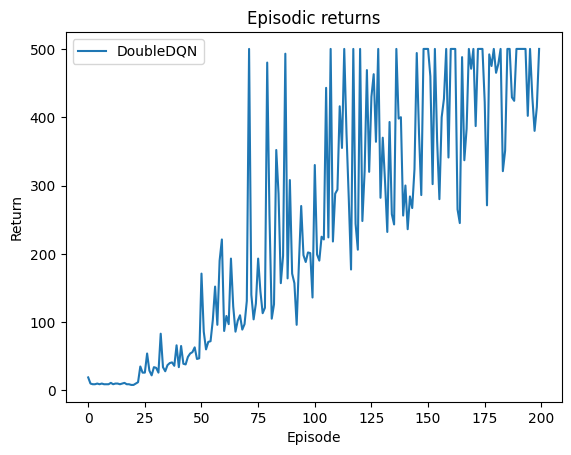

In [ ]:
# Create Environment
env = GymEnvironment(env_str)

# VanillaQValueNetwork class uses a simple mlp for approximating the Q values.
#  - Input dimension of the mlp = (state_dim + action_dim)
#  - Size of the intermediate layers are specified as list of `hidden_dims`.
hidden_dims = [64, 64]

# We will be using a one hot representation for representing actions. So take action_dim = num_actions.
Q_value_network = VanillaQValueNetwork(state_dim=env.observation_space.shape[0],  # dimension of the state representation
                                       action_dim=env.action_space.n,             # dimension of the action representation
                                       hidden_dims=hidden_dims,                   # dimensions of the intermediate layers
                                       output_dim=1)                              # set to 1 (Q values are scalars)

# Instead of using the 'network_type' argument, use the 'network_instance' argument.
# Pass Q_value_network as the `network_instance` to the `DoubleDQN` policy learner.
DoubleDQNagent = PearlAgent(
    policy_learner=DoubleDQN(
        state_dim=env.observation_space.shape[0],
        action_space=env.action_space,
        batch_size=64,
        training_rounds=10,
        soft_update_tau=0.75,
        network_instance=Q_value_network,   # pass an instance of Q value network to the policy learner.
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=env.action_space.n
        ),
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(10_000),
)

# The online learning function in Pearl implements environment interaction and learning
# and returns a dictionary with episodic returns
info_DoubleDQN = online_learning(
    agent=DoubleDQNagent,
    env=env,
    number_of_episodes=200,
    print_every_x_episodes=20,   # print returns after every 10 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    seed=0
)

env.close()

In [ ]:
# info["return"] refers to the episodic returns
torch.save(info_DoubleDQN["return"], "DoubleDQN-return.pt")
plt.plot(np.arange(len(info_DoubleDQN["return"])),
         info_DoubleDQN["return"],
         label="DoubleDQN")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

## Proximal Policy Optimization (PPO)

episode 50, step 1197, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 15.0
episode 100, step 2381, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 16.0
episode 150, step 4022, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 99.0
episode 200, step 5755, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 45.0
episode 250, step 7941, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 28.0
episode 300, step 10871, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 90.0
episode 350, step 17190, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 109.0
episode 400, step 23308, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=CartPole-v1
return: 17

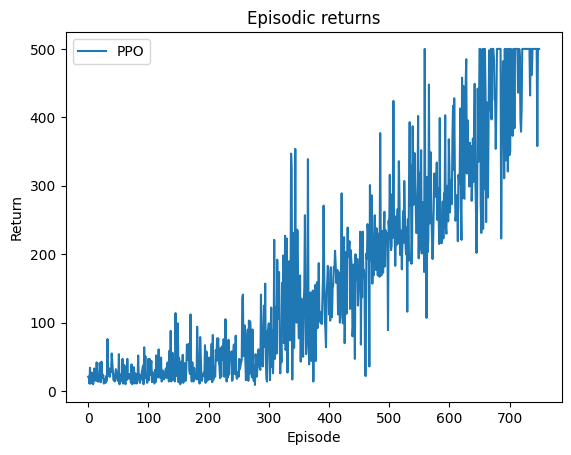

In [ ]:
# Create Environment
env = GymEnvironment(env_str)

# Create Pearl Agent
PPOagent = PearlAgent(
    policy_learner=ProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        use_critic=True,
        action_space=env.action_space,
        actor_hidden_dims=[64, 64],
        critic_hidden_dims=[64, 64],
        batch_size=64,
        training_rounds=10,
        critic_learning_rate=1e-3,
        actor_learning_rate=1e-3,
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=env.action_space.n,
        ),
    ),
    replay_buffer=OnPolicyReplayBuffer(250_000),
)

info_PPO = online_learning(
    agent=PPOagent,
    env=env,
    number_of_episodes=750,
    print_every_x_episodes=50,
    learn_after_episode=True,
    seed=0
)

env.close()

In [ ]:
# info["return"] refers to the episodic returns
torch.save(info_PPO["return"], "info_PPO-return.pt")
plt.plot(np.arange(len(info_PPO["return"])),
         info_PPO["return"],
         label="PPO")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

# LunarLander-v2

In [9]:
env_str = "LunarLander-v2"
env = GymEnvironment(env_str)
print(f"Gym Environment: {env_str}")
print(f"Observation Space: {env.observation_space.shape[0]}")
print(f"Number of Actions: {env.action_space.n}")
print(f"Action Space Dimensions: {env.action_space.action_dim}")
print(f"Is Action Space Continuous: {env.action_space.is_continuous}")
env.close()

Gym Environment: LunarLander-v2
Observation Space: 8
Number of Actions: 4
Action Space Dimensions: 1
Is Action Space Continuous: False


## Double DQN

In [ ]:
# Create Environment
env = GymEnvironment(env_str)

# VanillaQValueNetwork class uses a simple mlp for approximating the Q values.
#  - Input dimension of the mlp = (state_dim + action_dim)
#  - Size of the intermediate layers are specified as list of `hidden_dims`.
hidden_dims = [64, 64]


# We will be using a one hot representation for representing actions. So take action_dim = num_actions.
Q_value_network = VanillaQValueNetwork(state_dim=env.observation_space.shape[0],  # dimension of the state representation
                                       action_dim=env.action_space.n,             # dimension of the action representation
                                       hidden_dims=hidden_dims,                   # dimensions of the intermediate layers
                                       output_dim=1)                              # set to 1 (Q values are scalars)

# Create Pearl Agent
# Instead of using the 'network_type' argument, use the 'network_instance' argument.
# Pass Q_value_network as the `network_instance` to the `DeepQLearning` policy learner.
DoubleDQNagent = PearlAgent(
    policy_learner=DoubleDQN(
        state_dim=env.observation_space.shape[0],
        action_space=env.action_space,
        batch_size=64,
        network_instance=Q_value_network,   # pass an instance of Q value network to the policy learner.
        exploration_module=EGreedyExploration(0.025),
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=env.action_space.n
        ),
    ),
    replay_buffer=FIFOOffPolicyReplayBuffer(1_000_000),
)

info_DoubleDQN = online_learning(
    agent=DoubleDQNagent,
    env=env,
    number_of_episodes=3000,
    print_every_x_episodes=50,   # print returns after every 50 episdoes
    learn_after_episode=True,    # instead of updating after every environment interaction, Q networks are updates at the end of each episode
    record_period=50,
    seed=0
)

env.close()

episode 50, step 5603, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=LunarLander-v2
return: 163.88086873481768
episode 100, step 29940, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=LunarLander-v2
return: -239.8044647074421
episode 150, step 72820, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=LunarLander-v2
return: -114.45996482018381
episode 200, step 120463, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=LunarLander-v2
return: -81.69869864918292
episode 250, step 168982, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=LunarLander-v2
return: -93.05275978473946
episode 300, step 213942, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=LunarLander-v2
return: -30.920892796013504
episode 350, step 246941, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayBuffer, env=LunarLander-v2
return: 22.148227587342262
episode 400, step 275910, agent=PearlAgent with DoubleDQN, FIFOOffPolicyReplayB

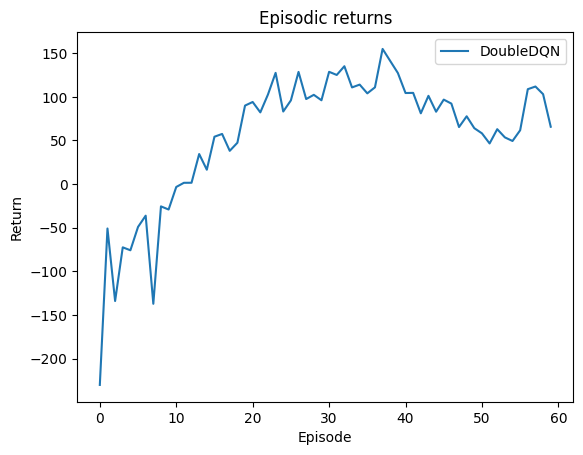

In [ ]:
# info["return"] refers to the episodic returns
torch.save(info_DoubleDQN["return"], "DoubleDQN-return.pt")
plt.plot(np.arange(len(info_DoubleDQN["return"])),
         info_DoubleDQN["return"],
         label="DoubleDQN")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

## Proximal Policy Optimization (PPO)

In [10]:
# Create Environment
env = GymEnvironment(env_str)

# Create Pearl Agent
PPOagent = PearlAgent(
    policy_learner=ProximalPolicyOptimization(
        state_dim=env.observation_space.shape[0],
        use_critic=True,
        action_space=env.action_space,
        actor_hidden_dims=[64, 64],
        critic_hidden_dims=[64, 64],
        critic_learning_rate=3e-4,
        actor_learning_rate=3e-4,
        batch_size=128,
        training_rounds=10,
        entropy_bonus_scaling=0.01,
        action_representation_module=OneHotActionTensorRepresentationModule(
            max_number_actions=env.action_space.n,
        ),
    ),
    replay_buffer=OnPolicyReplayBuffer(250_000),
)

info_PPO = online_learning(
    agent=PPOagent,
    env=env,
    #number_of_episodes=1000,
    number_of_steps=500_000,
    #print_every_x_episodes=50,
    print_every_x_steps=2048,
    learn_every_k_steps=2048,
    record_period=2048,
    learn_after_episode=False,
    seed=0
)

env.close()

/Users/michaelkudlaty/anaconda3/envs/PPOPearl/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


episode 23, step 2126, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: -515.9834594726562
episode 44, step 4142, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: -301.861083984375
episode 65, step 6162, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: -276.10418701171875
episode 88, step 8286, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: -121.37533569335938
episode 108, step 11086, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: 80.95977783203125
episode 122, step 12348, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: -128.26376342773438
episode 145, step 14338, agent=PearlAgent with ProximalPolicyOptimization, OnPolicyReplayBuffer, env=LunarLander-v2
return: -440.3533935546875
episod

KeyboardInterrupt: 

In [ ]:
PPOagent.policy_learner._actor._model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sequential(
  (0): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
  )
  (1): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=64, out_features=4, bias=True)
    (1): Softmax(dim=None)
  )
)

In [ ]:
# info["return"] refers to the episodic returns
torch.save(info_PPO["return"], "info_PPO-return.pt")
plt.plot(np.arange(len(info_PPO["return"])),
         info_PPO["return"],
         label="PPO")

plt.title("Episodic returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()